<a href="https://colab.research.google.com/github/emerson-matos/tcc-notebooks/blob/main/reviews/analise_exploratoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monta o google drive

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter

from google.colab import drive
sns.color_palette("tab10")
drive.mount('/content/gdrive')

from google.colab import auth
import gspread
from google.auth import default

auth.authenticate_user()

creds, _ = default()

gc = gspread.authorize(creds)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Baixe a lista de stopwords em português
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Dados dos hoteis

In [3]:
date = "2023/06/21"

## Cria o DataFrame

### conferindo a versão do sns

In [4]:
ws = gc.open('PGC-hotels')
emerson = ws.worksheet('Emerson')
hotels = pd.DataFrame(emerson.get_all_records())[['name', 'stars', 'overall_rating', 'region', 'state', 'qtd_reviews', 'source']]

sns.__version__

'0.12.2'

### carregando um unico arquivo

In [ ]:
filename = 'ramada-hotel-gm-reviews.csv'
dados = pd.read_csv(f"/content/gdrive/MyDrive/tcc/data/{date}/{filename}")
dados['source'] = filename.split('.')[0]
dados.loc[1]['text']

### carregando todos os arquivos da pasta

In [5]:
import glob
import os

path_to_lookup = f'/content/gdrive/MyDrive/tcc/data/{date}/'
file_pattern = "*.csv"

# setting the path for joining multiple files
files = os.path.join(path_to_lookup, file_pattern)

# list of merged files returned
files = glob.glob(files)

dados = pd.concat(map(lambda file: pd.read_csv(file).assign(source=file.split("/")[-1].split('-gm-reviews')[0]), files), ignore_index=True)

In [6]:
df = dados[['retrieval_date', 'rating', 'relative_date', 'likes', 'user_is_local_guide', 'text', 'source', 'user_reviews']].copy()

### Tratando dataset

#### marcando avaliações com mais de 2 caracteres

In [7]:
df['com_texto'] = df['text'].notna()
df['analisar'] = (df['text'].str.len() > 2) & (~df['text'].str.contains('Tradução do Google', na=False))
df['traduzido'] = df['text'].str.contains('Tradução do Google', na=False)

#### quantidade total de reviews

In [8]:
df.shape[0] ## reviews no total com e sem texto

128929

#### quantidade de reviews traduzidos ou com menos de 3 caracteres (2 ou menos)

In [9]:
sum(~df['analisar']) / df.shape[0] * 100

35.912013588874494

##### quantidade de reviews traduzidos e sem texto

In [10]:
sum(df['traduzido']) / df.shape[0] * 100 ## reviews traduzidos

7.069006972830007

In [11]:
sum(~df['com_texto']) / df.shape[0] * 100 ## reviews sem texto

28.834474788449455

#### quantidade de reviews que serão analisados

In [12]:
sum(df['analisar']) / df.shape[0] * 100 ## reviews com texto

64.08798641112551

#### preparando colunas

Transformamos a data relativa da realização do review em datetime e criamos novas colunas com partes dessa data e também quantidade de reviews de um usuario em um valor inteiro.

##### definindo transformações

In [13]:
from datetime import datetime, timedelta
import re

def transform_user_reviews(x):
  if isinstance(x, str) and x == 'Um':
    1
  elif isinstance(x, str):
    return int(x.replace('.',''))
  return x

# Função para detectar idioma, tratando valores nulos e textos vazios
def detectar_idioma(texto):
    if texto and len(texto) > 2:  # Verificar se o texto não é nulo e não está vazio
        try:
          lang = detect(texto)
          return lang
        except:
          print(f"deu ruim {texto}")

    return None

def obtem_data(row):
  # String de data relativa
  data_relativa_str = row.relative_date
  timestamp = row.retrieval_date

  # Converte a string em um objeto timedelta
  unidade_tempo = data_relativa_str.split()[1]
  quantidade_tempo = 1 if 'um' in data_relativa_str.split()[0] else int(data_relativa_str.split()[0])

  if 'segundo' in unidade_tempo:
      data_relativa = timedelta(seconds=quantidade_tempo)
  elif 'minuto' in unidade_tempo:
      data_relativa = timedelta(minutes=quantidade_tempo)
  elif 'hora' in unidade_tempo:
      data_relativa = timedelta(hours=quantidade_tempo)
  elif 'dia' in unidade_tempo:
      data_relativa = timedelta(days=quantidade_tempo)
  elif 'semana' in unidade_tempo:
      data_relativa = timedelta(weeks=quantidade_tempo)
  elif re.match(r"m(ê|e)s", unidade_tempo):
      data_relativa = timedelta(days=30*quantidade_tempo)
  elif 'ano' in unidade_tempo:
      data_relativa = timedelta(days=365*quantidade_tempo)
  else:
      return timestamp

  # Timestamp
  try:
    dt_timestamp = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f')
  except:
    dt_timestamp = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')

  return (dt_timestamp - data_relativa).date()

##### transformações rápidas

In [15]:
df['user_reviews'] = df['user_reviews'].apply(transform_user_reviews).fillna(0)

df['data_avaliacao'] = pd.to_datetime(df.apply(obtem_data, axis=1))

# Extract month and year from the 'date' column
df['mes_avaliacao'] = df['data_avaliacao'].dt.month
df['ano_avaliacao'] = df['data_avaliacao'].dt.year

# Create a new column representing the combination of month and year
df['mes_ano_avaliacao'] = df['data_avaliacao'].dt.to_period('M')

df['ano_avaliacao'].value_counts()

2022    36765
2019    20737
2023    20209
2020    17389
2021    13947
2018    13813
2017     4556
2016     1004
2015      277
2014      130
2013       88
2012       10
2011        4
Name: ano_avaliacao, dtype: int64

In [24]:
import unicodedata
filtered_df = df[df['analisar']].copy()
review_count = df[['source', 'rating', 'analisar']].groupby(['source', 'analisar']).size().reset_index(name='counts').sort_values('counts', ascending=False)

hotels['source_normalized'] = hotels['source'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode('utf-8'))
review_count['source_normalized'] = review_count['source'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode('utf-8'))

hotels_metadados = pd.merge(hotels, review_count, on="source_normalized")[['name', 'stars', 'overall_rating', 'region', 'state', 'counts', 'analisar']]

### analise exploratoria

#### exemplo

In [25]:
df.head()

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,com_texto,analisar,traduzido,data_avaliacao,mes_avaliacao,ano_avaliacao,mes_ano_avaliacao
0,2023-06-21 19:53:17.211961,5.0,2 dias atrás,1,False,"O Hotel é simplesmente incrível, atendentes su...",hotel-marsol-beach-resort,11,True,True,False,2023-06-19,6,2023,2023-06
1,2023-06-21 19:53:17.261651,5.0,2 dias atrás,0,True,(Tradução do Google) Muito poucos doces e sobr...,hotel-marsol-beach-resort,72,True,False,True,2023-06-19,6,2023,2023-06
2,2023-06-21 19:53:17.280373,5.0,2 dias atrás,0,False,Ótima localização. Amei o serviço! Voltarei co...,hotel-marsol-beach-resort,17,True,True,False,2023-06-19,6,2023,2023-06
3,2023-06-21 19:53:17.311936,5.0,3 dias atrás,0,False,"Aconchegante, bem localizado e com ótimo servi...",hotel-marsol-beach-resort,11,True,True,False,2023-06-18,6,2023,2023-06
4,2023-06-21 19:53:17.341585,5.0,5 dias atrás,0,False,É um ótimo hotel para levar a família e curtir...,hotel-marsol-beach-resort,2,True,True,False,2023-06-16,6,2023,2023-06


In [26]:
hotels_metadados

,name,stars,overall_rating,region,state,counts,analisar
0,Cana Brava All Inclusive Resort,4,4.6,NORDESTE,BA,8276,True
1,Cana Brava All Inclusive Resort,4,4.6,NORDESTE,BA,2711,False
2,Grand Oca Maragogi,5,4.3,NORDESTE,AL,2323,True
3,Grand Oca Maragogi,5,4.3,NORDESTE,AL,2290,False
4,Grand Palladium Imbassaí Resort & Spa,5,4.7,NORDESTE,BA,12644,True
5,Grand Palladium Imbassaí Resort & Spa,5,4.7,NORDESTE,BA,6866,False
6,Hotel Coroa Vermelha Beach All Inclusive,4,4.5,NORDESTE,BA,2313,True
7,Hotel Coroa Vermelha Beach All Inclusive,4,4.5,NORDESTE,BA,1721,False
8,Hotel Marsol Beach Resort,4,4.2,NORDESTE,RN,1947,True
9,Hotel Marsol Beach Resort,4,4.2,NORDESTE,RN,1322,False


In [18]:
df.describe()

,rating,likes,mes_avaliacao,ano_avaliacao
count,128929.000000,128929.000000,128929.000000,128929.000000
mean,4.639197,-0.181891,6.020895,2020.613981
std,0.837246,0.770786,1.625919,1.856210
min,1.000000,-1.000000,1.000000,2011.000000
25%,5.000000,-1.000000,6.000000,2019.000000
50%,5.000000,0.000000,6.000000,2021.000000
75%,5.000000,0.000000,6.000000,2022.000000
max,5.000000,32.000000,12.000000,2023.000000


In [19]:
df[['source', 'traduzido', 'com_texto', 'analisar']].groupby('source').agg(sum)

,traduzido,com_texto,analisar
source,,,
cana-brava-all-inclusive-resort,156,8434,8276
grand-oca-maragogi,604,2928,2323
grand-palladium-imbassaí-resort-&-spa,3710,16354,12644
hotel-coroa-vermelha-beach-all-inclusive,105,2418,2313
hotel-marsol-beach-resort,178,2125,1947
hotel-vila-galé---touros,117,4319,4201
hotel-vila-galé-marés,343,5657,5312
hotel-vila-galé:-eco-resort---cabo,194,3204,3009
iberostar-bahia,1637,10507,8869


In [20]:
valores = hotels_metadados.groupby(['state', 'analisar']).agg({'counts': [ 'sum', 'min', 'max' ], 'overall_rating': [ 'mean', 'min', 'max' ], 'stars': [ 'mean' ]})

valores

counts              overall_rating               stars
                  sum   min    max           mean  min  max      mean
state analisar                                                       
AL    False      7382  2019   3073       4.600000  4.3  4.8  4.666667
      True       9005  2323   4038       4.600000  4.3  4.8  4.666667
BA    False     31617   859   7241       4.563636  3.8  4.8  4.181818
      True      61390  1939  12644       4.563636  3.8  4.8  4.181818
PE    False      2361  2361   2361       4.500000  4.5  4.5  5.000000
      True       3009  3009   3009       4.500000  4.5  4.5  5.000000
RN    False      2741  1322   1419       4.400000  4.2  4.6  4.500000
      True       6148  1947   4201       4.400000  4.2  4.6  4.500000
SE    False      2200  2200   2200       4.300000  4.3  4.3  4.000000
      True       3076  3076   3076       4.300000  4.3  4.3  4.000000

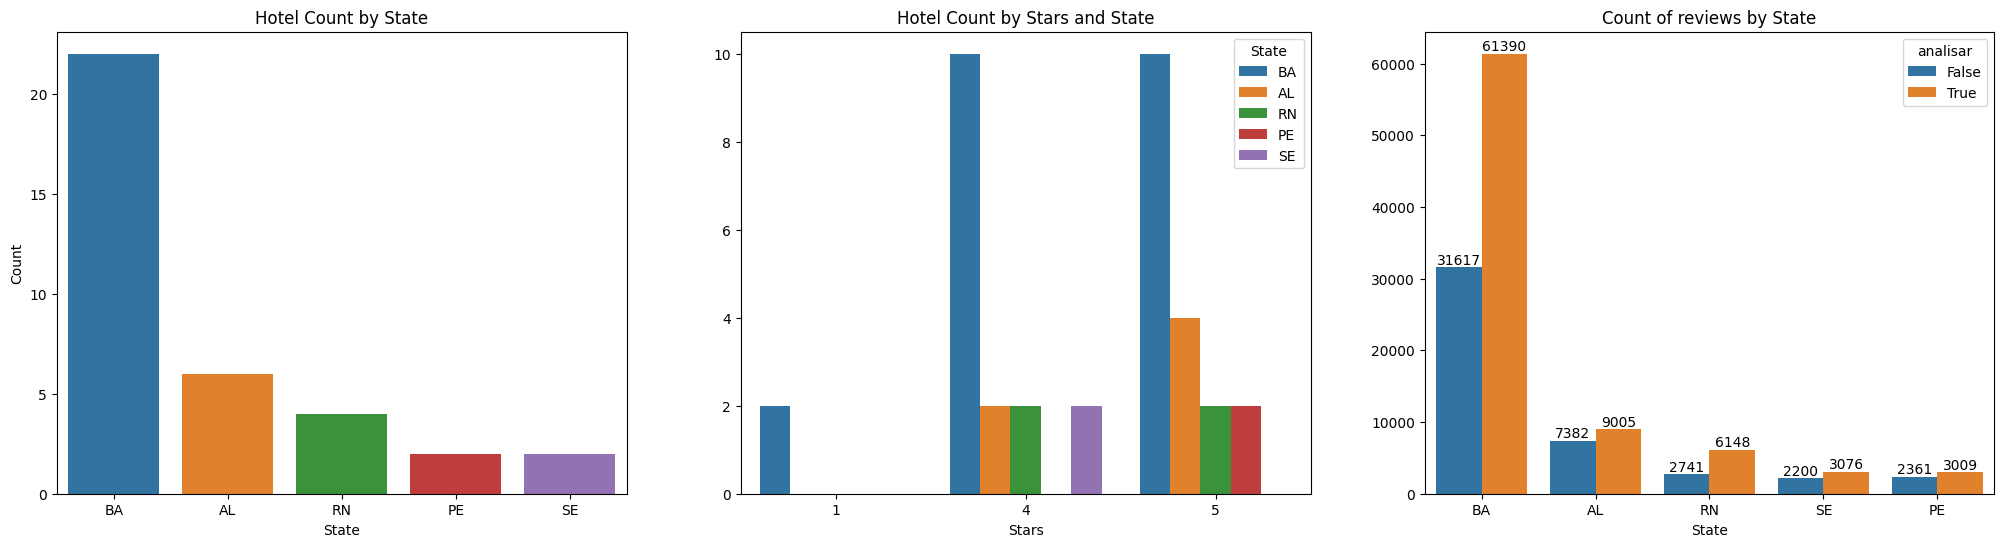

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
state_counts = hotels_metadados.groupby(['state', 'analisar'])['counts'].sum().reset_index().sort_values('counts', ascending=False)

sns.barplot(data=state_counts, x='state', hue='analisar', y='counts', ax=axes[2])
axes[2].set_title('Count of reviews by State')
axes[2].set_xlabel('State')
axes[2].set_ylabel('')

sns.countplot(data=hotels_metadados, x='state', ax=axes[0])
axes[0].set_title('Hotel Count by State')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Count')

sns.countplot(data=hotels_metadados, x='stars', hue='state', ax=axes[1])
axes[1].set_title('Hotel Count by Stars and State')
axes[1].set_xlabel('Stars')
axes[1].set_ylabel('')
axes[1].legend(title='State')

# Add count values on top of each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                       ha='center', va='bottom')
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Display the plots
plt.show()

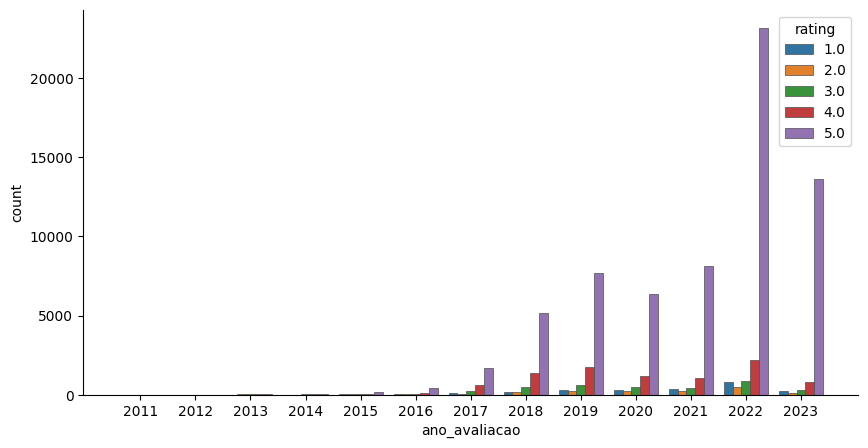

In [27]:
f, ax = plt.subplots(figsize=(10, 5))

sns.despine(f)

sns.countplot(
    x="ano_avaliacao",
    hue="rating",
    data=filtered_df,
    edgecolor=".3",
    linewidth=.5,
)
ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.autoscale()
plt.show()

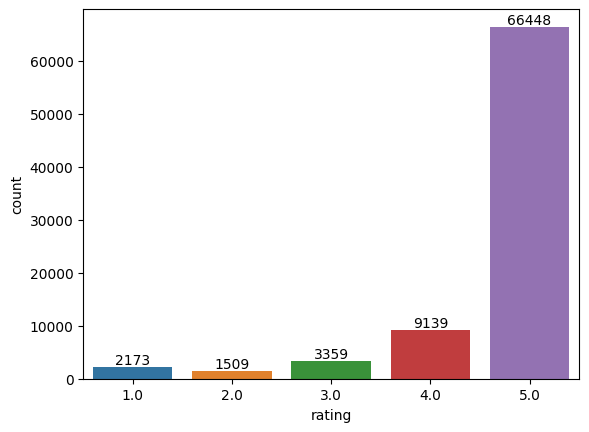

In [28]:
sns.countplot(x="rating", data=filtered_df)
# Add count values on top of each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                       ha='center', va='bottom')
plt.show()

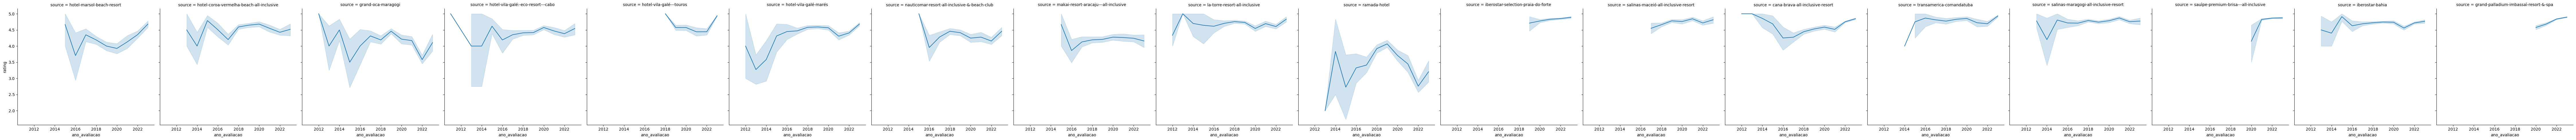

In [29]:
sns.relplot(
    x='ano_avaliacao',
    y='rating',
    col='source',
    kind="line",
    data=filtered_df
)
plt.show()

In [30]:
filtered_df[['rating', 'text', 'data_avaliacao', 'user_is_local_guide', 'user_reviews']].head()

,rating,text,data_avaliacao,user_is_local_guide,user_reviews
0,5.0,"O Hotel é simplesmente incrível, atendentes su...",2023-06-19,False,11
2,5.0,Ótima localização. Amei o serviço! Voltarei co...,2023-06-19,False,17
3,5.0,"Aconchegante, bem localizado e com ótimo servi...",2023-06-18,False,11
4,5.0,É um ótimo hotel para levar a família e curtir...,2023-06-16,False,2
5,5.0,Amei minhas férias amei esse lugar top,2023-06-16,False,22


<Figure size 1000x500 with 0 Axes>

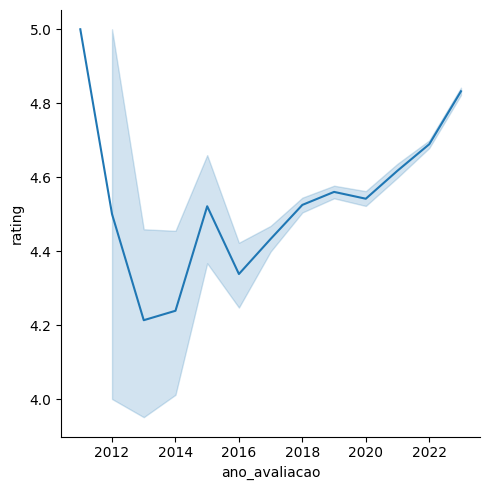

In [31]:
plt.figure(figsize=(10,5))
sns.relplot(x='ano_avaliacao', y='rating', kind="line", data=filtered_df)

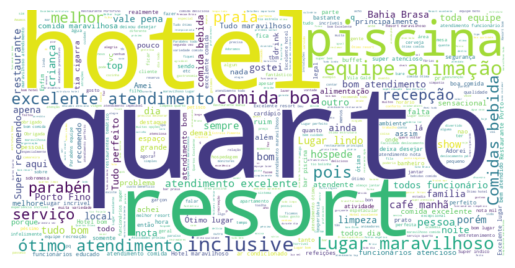

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string

# Concatenar todos os textos em uma única string
texto = ' '.join(filtered_df['text'].tolist())

# Tokenização das palavras
tokens = word_tokenize(texto)

# Obtenha as stopwords em português
stopwords_pt = set(stopwords.words('portuguese'))

# Remova as stopwords do texto
tokens_sem_pontuacao = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
tokens_sem_stopwords = [token for token in tokens_sem_pontuacao if token.lower() not in stopwords_pt]
# Junte as palavras novamente em um texto
texto_sem_stopwords = ' '.join(tokens_sem_stopwords)

# Criar um objeto WordCloud com as configurações desejadas
wc = WordCloud(background_color='white', max_words=1000, width=800, height=400)

# Gerar a nuvem de palavras
nuvem = wc.generate(texto_sem_stopwords)

# Exibir a nuvem de palavras
plt.imshow(nuvem, interpolation='bilinear')
plt.axis('off')
plt.show()

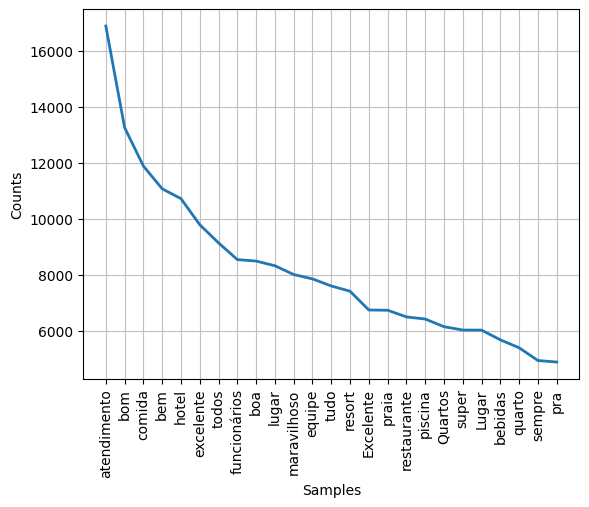

<Axes: xlabel='Samples', ylabel='Counts'>

In [34]:
from nltk.probability import FreqDist
palavras = texto_sem_stopwords.split()

contagem = FreqDist(palavras)

contagem.plot(25)

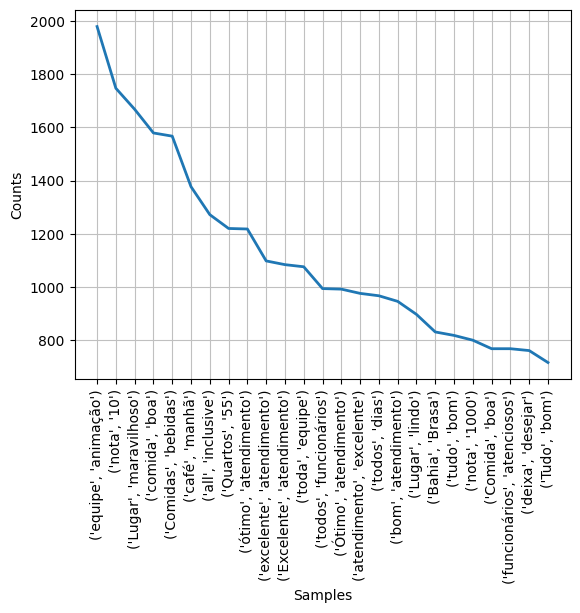

<Axes: xlabel='Samples', ylabel='Counts'>

In [36]:
#Create your bigrams
bgs = nltk.bigrams(palavras)

#compute frequency distribution for all the bigrams in the text
fdist = FreqDist(bgs)
fdist.plot(25)

# bert

https://medium.com/data-hackers/an%C3%A1lise-de-sentimentos-em-portugu%C3%AAs-utilizando-pytorch-e-python-91a232165ec0

https://sol.sbc.org.br/index.php/stil/article/view/17784

https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

In [37]:
!nvidia-smi

Fri Jun 23 03:40:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [40]:
!pip install -qq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.4 MB/s eta 0:00:00


In [76]:
import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, pipeline

In [72]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [85]:
nlp = pipeline("sentense-classification", model=model, tokenizer=tokenizer)

KeyError: ignored

In [84]:
nlp("Olá, meu cachorro ÉUMDeus")

[{'label': 'LABEL_0', 'score': 0.5444574952125549}]

In [80]:
classifications = [model.config.id2label[output] for output in [1,0]]
print(classifications)

['LABEL_1', 'LABEL_0']


In [75]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

input_ids = tokenizer("Olá, meu cachorro é uma gracinha", add_special_tokens=True)  # Batch size 1
outputs = model(input_ids).logits

classifications = np.argmax(outputs, axis=1)
print(classifications)

AttributeError: ignored

In [54]:
classifications = [model.config.id2label[output] for output in classifications]
print(classifications)

tensor(0.6474, grad_fn=<NllLossBackward0>)

In [65]:
logits

tensor([[[ 0.0052,  0.2779],
         [-0.2616,  0.0519],
         [-0.4440,  0.0658],
         [-0.3884,  0.0534],
         [ 0.0137,  0.3454],
         [ 0.0459, -0.1442],
         [ 0.0415,  0.5969],
         [-0.0696,  0.5114],
         [-0.1732,  0.1848],
         [ 0.0758,  0.0475],
         [-0.0493,  0.1323],
         [ 0.0087,  0.2787]]], grad_fn=<ViewBackward0>)

In [64]:
from transformers import BertTokenizer, BertForTokenClassification
import torch

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = BertForTokenClassification.from_pretrained(PRE_TRAINED_MODEL_NAME)

input_ids = torch.tensor(tokenizer.encode("Olá, meu cachorro é uma gracinha", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
labels = torch.tensor([1] * input_ids.size(1)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids, labels=labels)

logits = outputs.logits

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

In [ ]:
def to_sentiment(rating):
  rating = float(rating)
  if rating < 3:
    return 0
  elif rating > 4:
    return 2
  else:
    return 1

df['sentiment'] = df.rating.apply(to_sentiment)
df.head()

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
ax= sns.countplot(x=df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
%mkdir -p gdrive/MyDrive/tcc/bert
file_csv_data = 'gdrive/MyDrive/tcc/bert/reviews.csv'
df.to_csv(file_csv_data, index=None, header=True)

In [ ]:
sample_txt = df.loc[1]['text']
sample_txt

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=45,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

In [ ]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

In [ ]:
# deprecated sns.distplot(token_lens)
sns.histplot(token_lens,
             kde=True,
             stat="density",
             kde_kws=dict(cut=3),
             alpha=.4,
             edgecolor=(1, 1, 1, .4),
             )
plt.xlim([0, 600]);
plt.xlabel('Token count');

In [ ]:
max(token_lens)

In [ ]:
MAX_LEN = 512

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      #padding='longest',
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [ ]:
len(train_data_loader)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [ ]:
class SentimentClassifier(torch.nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = torch.nn.Dropout(p=0.3)
    #The last_hidden_state is a sequence of hidden states of the last layer of the model
    self.out = torch.nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)


In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc


In [ ]:
history

In [ ]:
history['train_acc']

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))


In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# 08

In [3]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from transformers import pipeline

model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
classifier = pipeline('sentiment-analysis', model=model_path, tokenizer=model_path)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [4]:
filtered_df['sentiment'] = filtered_df['text'].apply(lambda x: classifier(x).label)

NameError: ignored

In [10]:

sentences = [
  "Gostei muito do vídeo!",
  "Não estou feliz com os resultados."
]

result = classifier("Gostei muito do vídeo!")

AttributeError: ignored

In [11]:
result

[{'label': 'positive', 'score': 0.9314153790473938}]